[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Grape vine-210520-Healthy-zz-V1-20210225102831**, datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_tensorflow_transfer_learning.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to train an autoencoder using Keras and TensorFlow for removing noise from input images.

Autoencoders are a type of unsupervised neural network (i.e., no class labels or labeled data). As shown in the figure below, typically, autoencoders have two components/subnetworks:

1. **Encoder**: Accepts the input data and compresses it into a latent-space representation (i.e., a single vector that compresses and quantifies the input).
2. **Decoder**: The decoder is responsible for accepting the latent-space representation and then reconstructing the original input.

<img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png" width='350'>

Autoencoders are basically a technique for data compression, similar to the way an audio file is compressed using MP3, or an image file is compressed using JPEG. The aim of the autoencoder is to find a model (weights) which will require the minimum information to encode the image such that it can be recreated on the decoder side.

If we use too few neurons in the bottleneck layer (last layer), the capacity to recreate the image will be limited and  created images could be blurry or distorted. On the other hand, if the encoder uses too many neurons, then there is no compression. 

Moreover, autoencoders are typically used for:

1. **Dimensionality reduction**: If all the activation functions used within the autoencoder are linear, the latent variables present at the bottleneck, correspond to the principal components from PCA.
2. **Denoising**
3. **Anomaly/outlier detection** (e.g.: detecting mislabeled data points in a dataset or detecting when an input data point falls well outside our typical data distribution).

In **agriculture**, researchers have used autoencoders for anomaly/novelty detection (Alexandridis et al., 2017) and denoising (Wen et al., 2015).

#### Library Imports

In [99]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

#### Auxiliar functions

In [100]:
# Function for plotting images.
def plot_sample(X):
    # Plotting 9 sample images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(8, 8))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis("off")
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])


def read_data(path_list, im_size=(224, 224)):

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}
    print(tag2idx)

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                # im = quantize_image(im)
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)

    return X, y, tag2idx

#### Experimental Constants

In [101]:
INPUT_SHAPE = (256, 256, 3)
IM_SIZE = (256, 256)
NUM_EPOCHS = 500
BATCH_SIZE = 8
TEST_SPLIT = 0.15
BASE_LEARNING_RATE = 1e-3
RANDOM_STATE = 2021
VERBOSE_LEVEL = 1
AUTO = tf.data.AUTOTUNE
# Datasets' paths we want to work on.
PATH_LIST = ["../eden_library_datasets/Grape vine-210520-Healthy-zz-V1-20210225102831"]

#### Loading Data

In [102]:
X, y, tag2idx = read_data(PATH_LIST, IM_SIZE)

  0%|          | 1/444 [00:00<01:09,  6.34it/s]

{'Grape vine-210520-Healthy-zz-V1-20210225102831': 0}


 66%|██████▋   | 295/444 [00:52<00:20,  7.13it/s]

Not a picture


100%|██████████| 444/444 [01:19<00:00,  5.57it/s]


#### Displaying Original Images

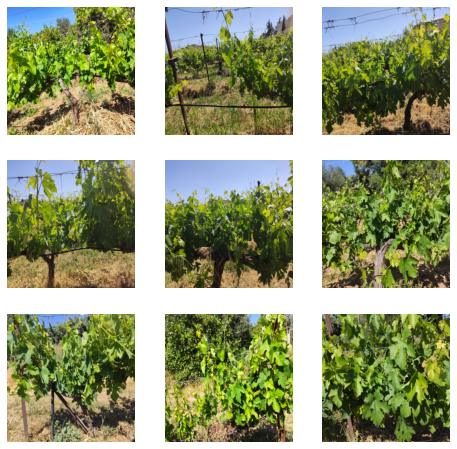

In [103]:
plot_sample(X)

#### Splitting data between train and test

In [104]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT, shuffle=True, stratify=y, random_state=RANDOM_STATE
)

#### Pre-processing

In [105]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

#### Adding noise to the original images

In [106]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0.0, clip_value_max=1.0)

#### Displaying Noisy Images

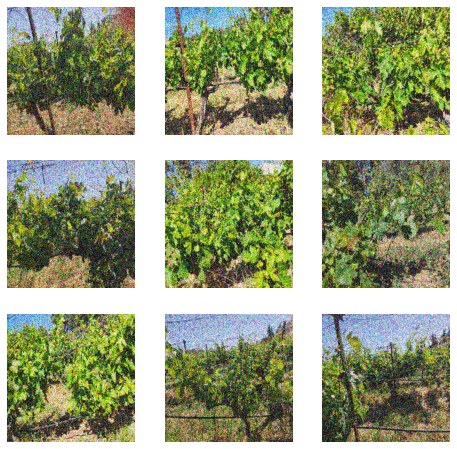

In [107]:
plot_sample(x_train_noisy)

#### Defining Autoencoder

In [108]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.Input(shape=(256, 256, 3)),
                layers.Conv2D(
                    128, (3, 3), activation="relu", padding="same", strides=2
                ),
                layers.Conv2D(64, (3, 3), activation="relu", padding="same", strides=2),
                layers.Conv2D(
                    32, (3, 3), activation="relu", padding="same", strides=2
                ),  # 32x32*32 VS 256X256X3
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Conv2DTranspose(
                    64, kernel_size=3, strides=2, activation="relu", padding="same"
                ),
                layers.Conv2DTranspose(
                    128, kernel_size=3, strides=2, activation="relu", padding="same"
                ),
                layers.Conv2DTranspose(
                    256, kernel_size=3, strides=2, activation="relu", padding="same"
                ),
                layers.Conv2D(
                    3, kernel_size=(3, 3), activation="sigmoid", padding="same"
                ),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#### Creating Autoencoder

In [109]:
autoencoder = Denoise()

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
)

#### Defining callbaks for improving training efficiency

In [110]:
# If val_loss doesn't improve for a number of epochs set with 'patience' parameter
# the current learning rate is multiplied by 'factor'(0.8).
reduce_lr = (
    ReduceLROnPlateau(
        monitor="val_loss", mode="min", factor=0.8, patience=NUM_EPOCHS // 20, verbose=1
    ),
)
# If val_loss doesn't improve for a number of epochs set with 'patience' parameter
# training will stop to avoid overfitting.
early_stopping = (
    EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=NUM_EPOCHS // 15,
        verbose=1,
        restore_best_weights=True,
    ),
)

#### Training the AutoEncoder for removing noise

In [111]:
autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/500
47/47 [==============================] - 3s 51ms/step - loss: 0.0550 - val_loss: 0.0328
Epoch 2/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0261 - val_loss: 0.0198
Epoch 3/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0182 - val_loss: 0.0165
Epoch 4/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 5/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 6/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 7/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 8/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 9/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 10/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0121 - val_loss: 0.0115

47/47 [==============================] - 2s 48ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 83/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 84/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 85/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 86/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 87/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 88/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 89/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 90/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 91/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0083 - val_loss: 0.0088
Epo

Epoch 162/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 163/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 164/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 165/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 166/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 167/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0078 - val_loss: 0.0078

Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 168/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 169/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 170/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0077 - val_loss: 0.0078
E

Epoch 240/500
47/47 [==============================] - 2s 47ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 241/500
47/47 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 242/500
47/47 [==============================] - 2s 47ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 243/500
47/47 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 244/500
47/47 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 245/500
47/47 [==============================] - 2s 47ms/step - loss: 0.0076 - val_loss: 0.0077

Epoch 00245: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
Epoch 246/500
47/47 [==============================] - 2s 47ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 247/500
47/47 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 248/500
47/47 [==============================] - 2s 46ms/step - loss: 0.0076 - val_loss: 0.0077


Epoch 318/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 319/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 320/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0075 - val_loss: 0.0076

Epoch 00320: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
Epoch 321/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 322/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 323/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 324/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 325/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 326/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0075 - val_loss: 0.0077


Epoch 396/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 397/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 398/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 399/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 400/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 401/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 402/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 403/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 404/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 405/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0075

Epoch 474/500
47/47 [==============================] - 2s 50ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 475/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 476/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 477/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 478/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 479/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 480/500
47/47 [==============================] - 2s 49ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 481/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 482/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 483/500
47/47 [==============================] - 2s 48ms/step - loss: 0.0074

#### Removing noise with the trained autoencoder

In [115]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

#### Displaying noisy and denoised images

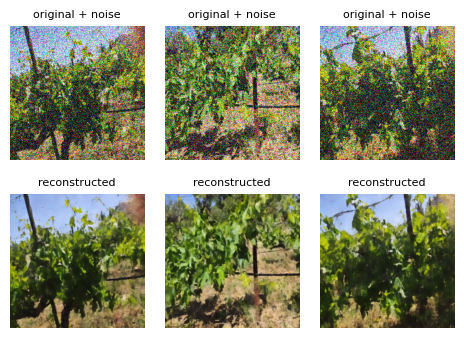

In [116]:
n = 3
plt.figure(figsize=(8, 4), dpi=100)
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise", fontsize=8)
    plt.imshow(x_test_noisy[i])
    ax.axis("off")

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed", fontsize=8)
    plt.imshow(decoded_imgs[i])
    bx.axis("off")

plt.subplots_adjust(wspace=-0.5, hspace=0.25)
plt.show()

## Image Compression
256 x 256 x 3 (196,608) -> 32 x 32 x 32 (32,768)

In [117]:
autoencoder.summary()

Model: "denoise_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_26 (Sequential)   (None, 32, 32, 32)        95840     
_________________________________________________________________
sequential_27 (Sequential)   (None, 256, 256, 3)       394435    
Total params: 490,275
Trainable params: 490,275
Non-trainable params: 0
_________________________________________________________________


## Possible Extensions
1. Change the number of epochs used while training (500 in this notebook).
2. Use other dataset from the <a href="https://edenlibrary.ai">Eden platform</a>.
3. Change the learning rate used while fine-tuning (1e-3 in this notebook).

## References
Alexandridis, T., Tamouridou, A.A., Pantazi, X., Lagopodi, A., Kashefi, J., Ovakoglou, G., Polychronos, V., & Moshou, D. (2017). Novelty Detection Classifiers in Weed Mapping: Silybum marianum Detection on UAV Multispectral Images. Sensors (Basel, Switzerland), 17.

Wen, C., Wu, D., Hu, H., & Pan, W. (2015). Pose estimation-dependent identification method for field moth images using deep learning architecture. Biosystems Engineering, 136, 117-128.

https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368

https://blog.keras.io/building-autoencoders-in-keras.html

https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/